In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pylab as plt
import torch
import scipy.stats.distributions as dist


import swyft
DEVICE = 'gpu' if torch.cuda.is_available() else 'cpu'

In [3]:
SIGMA = 0.1

In [4]:
class SimulatorBlob(swyft.Simulator):
    def __init__(self, bounds = None, Npix = 64, sigma = None):
        super().__init__()
        self.transform_samples = swyft.to_numpy32
        self.theta_sampler = swyft.RectBoundSampler([dist.uniform(4.00, 0.001)])
        self.bounds = bounds
        self.Npix = Npix
#        self.sigma = sigma
        self.powersampler = swyft.utils.PowerSpectrumSampler2((Npix, Npix))
        self.sigma = torch.ones(Npix, Npix)*SIGMA
#        self.sigma[:,:Npix//2] *= 1000

    def get_pk_fn(self, theta):
        return lambda k: 1e-3*(k+0.05)**-theta[0]
        
    def sample_delta(self, pk_fn, use_bounds = True):
        if self.bounds is not None and use_bounds:
            i = np.random.randint(len(self.bounds))
            return torch.tensor(self.bounds[i])
        else:
#            return self.powersampler.sample(lambda k: 1e6*3*(k/0.5)**-theta[0])
            return self.powersampler.sample(pk_fn)

    def psf(self, rho):
        return rho
            
    def build(self, graph):
        theta = graph.node("theta", self.theta_sampler)
        pk_fn = graph.node("pk_fn", self.get_pk_fn, theta)
        delta = graph.node("delta", self.sample_delta, pk_fn)
#        delta_unbound = graph.node("delta_unbound", lambda pk_fn: self.sample_delta(pk_fn, use_bounds = False), pk_fn)
#        rho = graph.node("rho", lambda delta: torch.exp(delta/5), delta)
#        x = graph.node("x", lambda rho: self.psf(rho) + torch.randn(self.Npix, self.Npix)*self.sigma, rho)
        x = graph.node("x", lambda delta: delta + torch.randn(self.Npix, self.Npix)*self.sigma, delta)
#        z = graph.node("test", lambda: lambda x: x)

/home/weniger/.conda/envs/lensing/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525539683/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


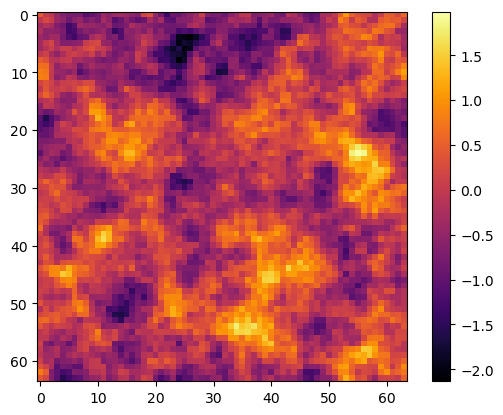

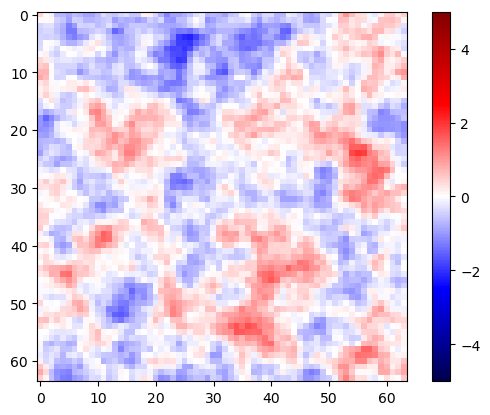

-0.065790676


0.58682966

In [5]:
NPIX = 64
sim = SimulatorBlob(Npix = NPIX)
sample0 = sim.sample(conditions = dict(theta = np.array([4.])))
del sample0['pk_fn']
plt.imshow(sample0['x'], cmap = 'inferno')
plt.colorbar()
plt.show()
plt.imshow(sample0['delta'], vmin = -5, vmax = 5, cmap = 'seismic')
plt.colorbar()
plt.show()
print(sample0['delta'].mean())
sample0['delta'].std()

In [6]:
def hook(sample):
#    print(sample)
    sample['x'] = sample['delta'] + np.random.randn(*sample['delta'].shape)*SIGMA
    return sample

The logic is the following:

We approximate the precision matrix of the inference problem like
$$
Q = W^T A^T D A W
$$
where $W$ is a wavelet transform, $A$ corresponds to correlations, and $D$ is a diagonal matrix.

As a starting point, I can assume that $W$ and $A$ are unit matrices.

For the loss function, we need independent noise realisations $n$, ideally such that $n^T (Q+\Sigma_{prior}^{-1}) n$ is low-variance.

Default could be just Gaussian random noise for now. Otherwise random prior draws.

In [8]:
samples = sim.sample(64*64, exclude = ['pk_fn'])
pk0 = sim.sample()['pk_fn']

  0%|          | 0/4096 [00:00<?, ?it/s]

In [9]:
samples[0].keys()

dict_keys(['theta', 'delta', 'x'])

In [10]:
class L(torch.nn.Module):
    def __init__(self, logD, W = None, W_T = None, A = None, A_T = None, Q_prior = None):
        super().__init__()
        self.logD = torch.nn.Parameter(logD)
        self.W = W if W else lambda x: x 
        self.W_T = W_T if W else lambda x: x 
        self.A = A if A else lambda x: x
        self.A_T = A_T if A else lambda x: x
        self.Q_prior = Q_prior if Q_prior else lambda x: x*0
        
    @property
    def D(self):
        """Returns diagonal components of D."""
        return torch.exp(self.logD*0 + self.logD[0])
    
    def Q(self, x):
        """Applies Q = W.T A.T D A W."""
        x = self.W(x)
        x = self.A(x)
        x = self.D*x
        x = self.A_T(x)
        x = self.W_T(x)
        return x
    
    def __call__(self, z_est, z):
#        print("z_est, z =", z_est.shape, z.shape)
        idx = torch.randperm(len(z))
#        N = z[idx] #- z_est[idx].detach()
        N = torch.randn_like(z)*z.std()# + z[idx]
#        print("N =", N.shape)
#        print("Q(z) =", self.Q(z-z_est).shape)
        loss = 0.5*((self.Q(z-z_est)+self.Q_prior(z-z_est))*N)**2 - (self.Q(N)+self.Q_prior(N))*N
        loss = loss.reshape(-1)
        return swyft.AuxLoss(loss, 'x')

class Network(swyft.AdamWReduceLROnPlateau, swyft.SwyftModule):
    def __init__(self):
        super().__init__()
        self.learning_rate = 1e-2
        self.early_stopping_patience = 10000
        self.estimator = torch.nn.Sequential(
            torch.nn.Unflatten(0, (-1, 1)),  # add color dimension
            torch.nn.Conv2d(1, 1, 9, padding=4),
            torch.nn.Flatten(0, 1),  # remove color dimension
        )
        W = torch.nn.Flatten(1, 2)
        W_T = torch.nn.Unflatten(1, (NPIX, NPIX))
        # TODO: Implement
        UT, D, U = sim.powersampler.covariance_decomposition(pk0)
        self.D = torch.nn.Parameter(D, requires_grad = False)
        prior_Q = lambda x: UT(U(x)/self.D)
        self.L = L(-3*torch.ones(NPIX*NPIX), W = W, W_T = W_T, Q_prior = prior_Q)

    def forward(self, A, B):
        x = A['x']
#        print("x =", x.shape)
        z_est = self.estimator(x)
        z = B['delta'][:len(x)]
#        print("z =", z.shape)
        return self.L(z_est, z), z_est

In [14]:
trainer = swyft.SwyftTrainer(accelerator = DEVICE, precision = 64, max_epochs = 10)
dm = swyft.SwyftDataModule(samples, batch_size=64, on_after_load_sample=hook)
network = Network()
trainer.fit(network, dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/weniger/.conda/envs/lensing/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /gpfs/home2/weniger/swyft/notebooks/dev/lightning_logs/version_4510659/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Reloading best model: /gpfs/home2/weniger/swyft/notebooks/dev/lightning_logs/version_4510659/checkpoints/epoch=9-step=520.ckpt


0.9777237941278519
tensor([0.1026, 0.1026, 0.1026,  ..., 0.1026, 0.1026, 0.1026],
       dtype=torch.float64, grad_fn=<PowBackward0>)
0.10260206412335138 0.0


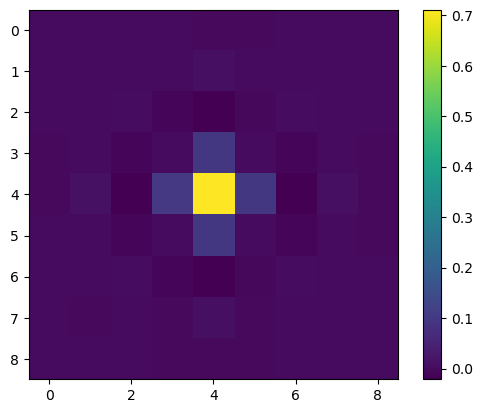

In [15]:
network.cpu()
kernel = network.estimator[1].weight.detach().numpy()[0,0]
print(kernel.sum())
plt.imshow(kernel)
print(network.L.D**-0.5)
print((network.L.D**-0.5).mean().item(), (network.L.D**-0.5).std().item())
plt.colorbar()

The GEDA sampler should directly provide noise sampels from the images, without intermediate steps or transformations.

- $U_2$, $D_2$ and $U_2^T$ are all defined in real space, going from $(N, N, N) \rightarrow (N*N*N,)$ and back
- The same is true for $G_1$ etc.

Consequences for GEDA:
- $\theta$ is in image space (updated according to coupling-strength constrained prior)
- $u_1$ is in in image space (updated according to coupling strength)
- $u_2$ is in vector space of $Q_1$ (updated according to likelihood precision)

tensor(0.9910, dtype=torch.float64)

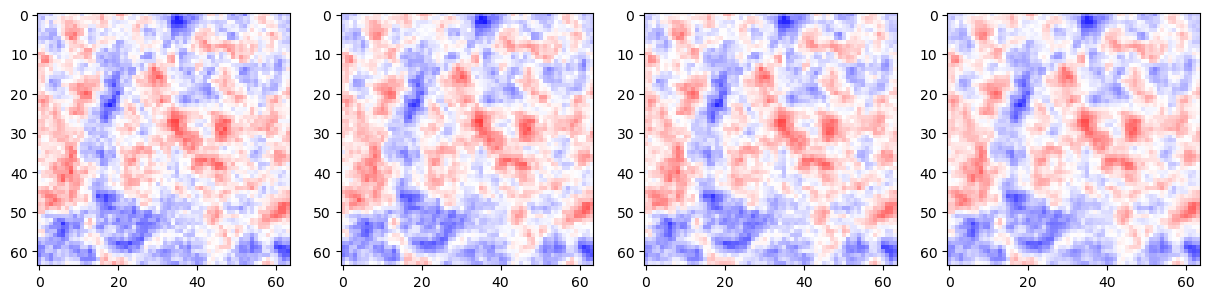

In [18]:
#pk = sim.sample()['pk_fn']
U2T, invD2, U2 = sim.powersampler.covariance_decomposition(pk0)
D2 = 1/invD2
D1 = network.L.D.detach().cpu()
G1 = torch.nn.Flatten(-2)
G1T = torch.nn.Unflatten(-1, (NPIX, NPIX))

i = 3
x = torch.tensor(samples[i]['x']).double()
d = torch.tensor(samples[i]['delta']).double()
mu = network.estimator(x.unsqueeze(0)).squeeze(0).cpu().detach()

sampler = swyft.utils.GEDASampler2(1e-2, G1, D1, G1T, U2, D2, U2T, out_shape = (NPIX, NPIX), mu = mu)
s = sampler.sample(1, steps=1000, initialize_with_Q2=True)[0]
plt.figure(figsize = (15, 5))
plt.subplot(141)
plt.imshow(x, vmin = -5, vmax = 5, cmap = 'seismic')
plt.subplot(142)
plt.imshow(d, vmin = -5, vmax = 5, cmap = 'seismic')
plt.subplot(143)
plt.imshow(s, vmin = -5, vmax = 5, cmap = 'seismic')
plt.subplot(144)
plt.imshow(mu, vmin = -5, vmax = 5, cmap = 'seismic')
s.std()/d.std()